<a href="https://colab.research.google.com/github/Zixuan-YU/datasciencecoursera/blob/main/FinalProject_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Enter your JHED ID Here for participation and feedback.
jhed_id="zyu64"

import requests
def sub_ans(team,question_num,answer):
    url='https://bids-class.azurewebsites.net/submit-answer'
    data={'class':'imaginf',
         'module':3,
         'team':team,
         'question_num':question_num,
         'answer_num':answer}
    x=requests.post(url,data=data)
    if x.status_code==200:
        return True
    else:
        return False

if jhed_id != '':
  print("Success {}, you are ready to go".format(jhed_id))
else:
  print("Please go back and enter your JHED_ID!")

Success zyu64, you are ready to go


# My Training Code

In [5]:
# Let's get everything installed (if it isn't already)
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import sklearn" || pip install -q scikit-learn
!python -c "import nibabel" || pip install -q nibabel  # This will let us work with NIfTI files
!python -c "import pydicom" || pip install -q pydicom  # This will let us work with DICOM files
%matplotlib inline

from monai.utils import set_determinism
set_determinism(seed=1876)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pydicom'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.0 MB/s eta 0:00:00


In [ ]:
print('/content/chestxray_training_data/2.25.94508877487811863339564123565666136380.02.dcm')

/content/chestxray_training_data/2.25.94508877487811863339564123565666136380.02.dcm


In [6]:

import numpy as np
from pydicom import dcmread
from torch.utils.data import Dataset

def from_binary(bin_array):
    output = np.zeros(bin_array.shape[:-1], dtype=np.uint8)
    for i in range(bin_array.shape[-1]):
        output[bin_array[..., i] == 1] = i + 1
    return output

class DicomDataset(Dataset):
    """
    Loads image/segmentation pairs of Nifti files from the given filename lists.
    Transformations can be specified or the image and segmentation arrays separately.
    """

    def __init__(self, image_filepaths, seg_filepaths, transform=None):
        """
        Initializes the dataset with the image and segmentation filename lists.

        Args:
            image_files (list of str): list of image filenames
            seg_files (list of str): if in segmentation task, list of segmentation filenames
            transform (Callable, optional): transform to apply to output dict (USE DICT TRANSFORMS)
        """

        if len(image_filepaths) != len(seg_filepaths):
            raise ValueError('Must have same number of image and segmentation files')
        
        self.image_files, self.seg_files = self.load_data(image_filepaths, seg_filepaths)
        self.transform = transform
    
    @staticmethod
    def load_data(image_filepaths, seg_filepaths):
        # We are just going to stack the volumes up so that we can select axial slices from 1 axis
        return (
            np.stack([dcmread(img_path).pixel_array.T for img_path in image_filepaths], axis=-1),
            np.stack([from_binary(dcmread(seg_path).pixel_array.transpose(2, 1, 0)) for seg_path in seg_filepaths], axis=-1),
        )

    def __len__(self):
        return self.image_files.shape[-1]

    def __getitem__(self, index):
        return self.transform({
            'img': self.image_files[:, :, index],
            'seg': self.seg_files[:, :, index],
        })

In [12]:
import tempfile
from pathlib import Path
from monai.apps import download_and_extract
root_dir = Path('/content')
resource = "https://drive.google.com/uc?id=1Sx8emP4YTatibxC55BFSVIa6Fy45aYBf"
md5 = "f2e9fb922a4a3fd28a9bf5b44488428a"  # A hash value to check the integrity of our download

compressed_file = root_dir / "chestxray_training_data.zip"  # Specify out download locations (Path objects use "/" to combine)
data_dir = root_dir / "chestxray_training_data"
download_and_extract(resource, compressed_file, root_dir, md5)

Downloading...
From: https://drive.google.com/uc?id=1Sx8emP4YTatibxC55BFSVIa6Fy45aYBf
To: /tmp/tmpwz0amsat/chestxray_training_data.zip
100%|██████████| 14.5M/14.5M [00:00<00:00, 113MB/s] 

2023-05-18 06:08:40,990 - INFO - Downloaded: /content/chestxray_training_data.zip
2023-05-18 06:08:41,024 - INFO - Verified 'chestxray_training_data.zip', md5: f2e9fb922a4a3fd28a9bf5b44488428a.
2023-05-18 06:08:41,026 - INFO - Writing into directory: /content.


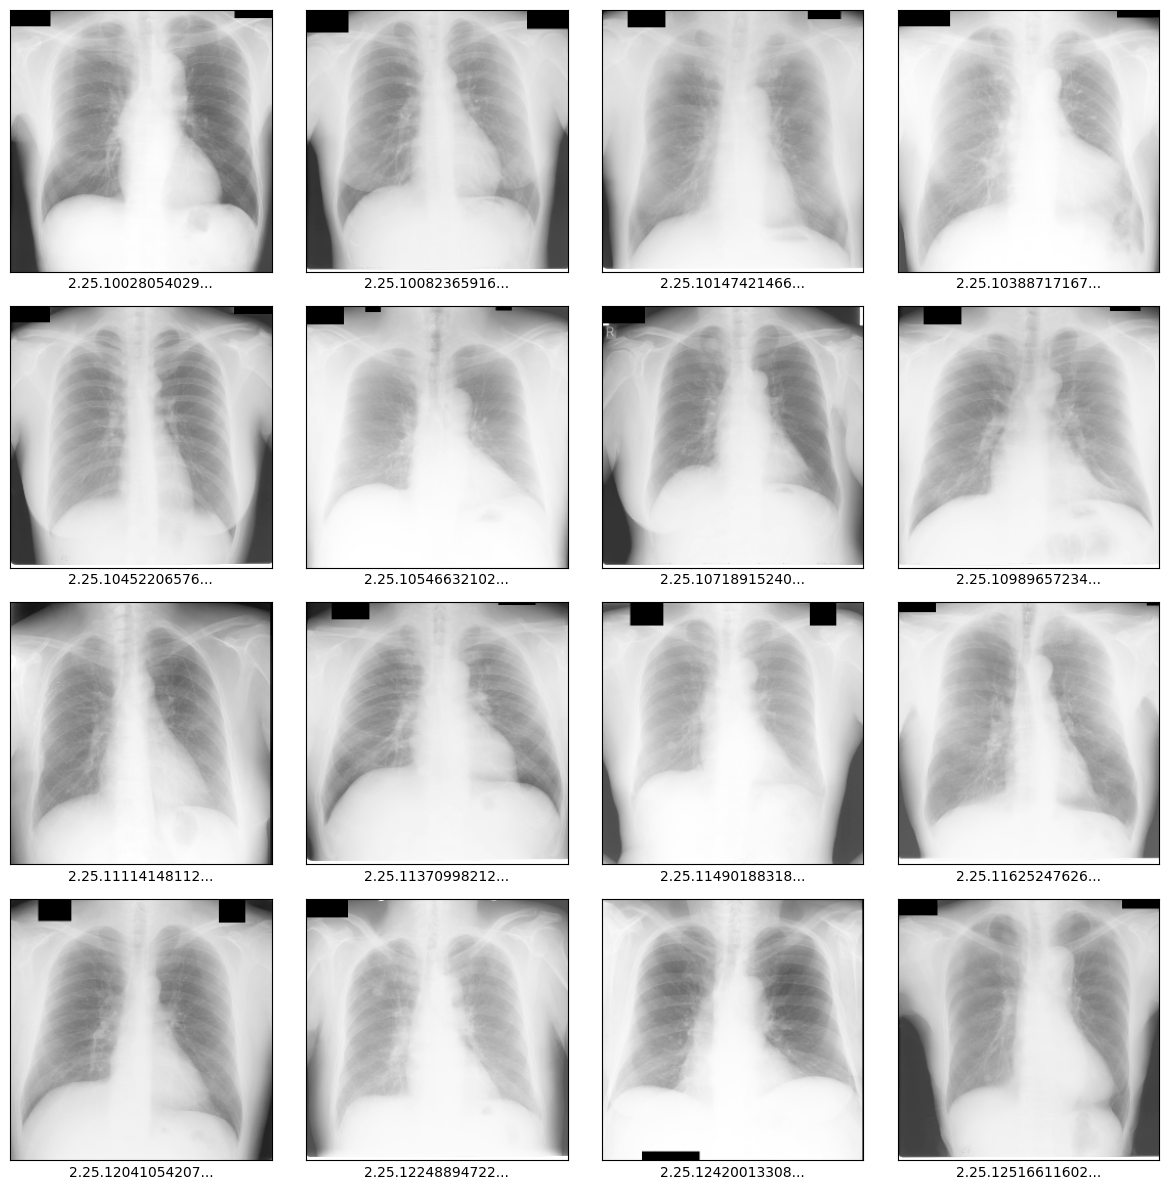

In [13]:
import matplotlib.pyplot as plt
from pydicom import dcmread
from pathlib import Path


train_image_files = sorted(data_dir.glob('*.01.dcm'))  # Grab the DX images from the training set (*.01.dcm)

# Go through each 3D volume and pick the middle axial slice to show
plt.subplots(4, 4, figsize=(12, 12))
for i, image_file in enumerate(train_image_files[:16]):
    ds = dcmread(image_file)  # Load the file into a Python object
    im = ds.pixel_array.T   # Get the image data as a numpy array
    plt.subplot(4, 4, i + 1)
    plt.xlabel(image_file.name[:16] + '...')
    plt.imshow(im.T, cmap="gray")  # Why do we need this transpose (.T) here?
    plt.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

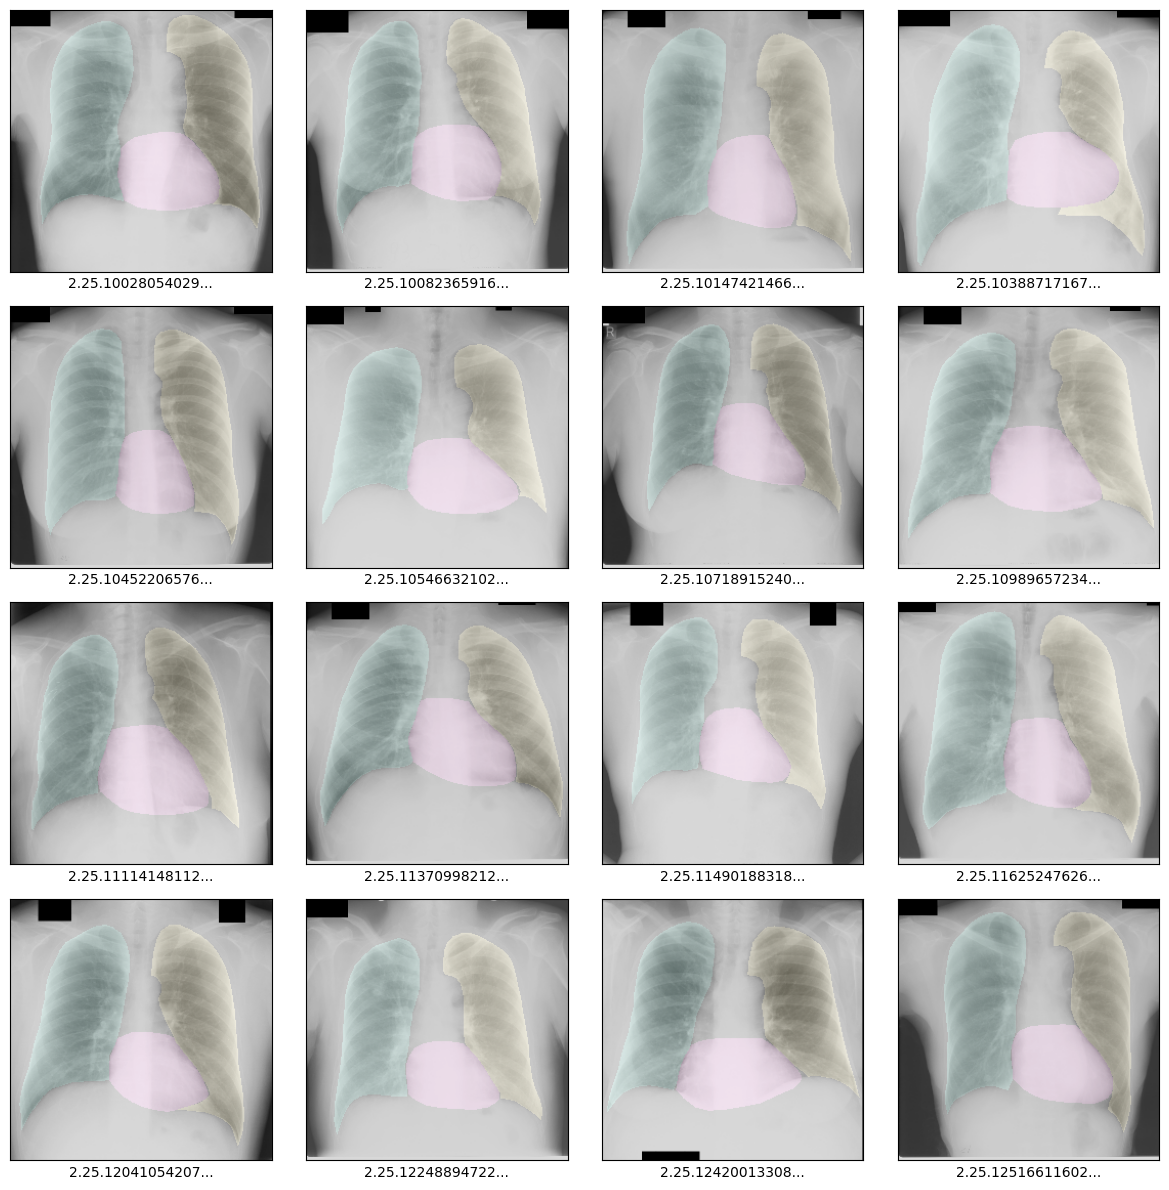

In [14]:
import numpy as np

LUT = {  # Using a accessible color palette
    1: (68, 170, 153),
    2: (221, 204, 119),
    3: (170, 68, 153)
}

train_label_files = [filename.parent / filename.name.replace('.01.dcm', '.02.dcm') for filename in train_image_files]

plt.subplots(4, 4, figsize=(12, 12))
for i, (image_file, label_file) in enumerate(zip(train_image_files[:16], train_label_files[:16])):
    ds = dcmread(image_file)  # Get the dicom files as a python object
    im = ds.pixel_array.T  # Get the image data as a numpy array

    # Normalize the image values to match color map (0, 255)
    im = im - np.min(im)
    im = np.array(im / np.percentile(im, 99) * 255.0)  # Why not use the max?
    im[im > 255] = 255
    im = im.astype(np.ubyte)  # Need integer values

    lbl = from_binary(dcmread(label_file).pixel_array.transpose(2, 1, 0))  # Get the label data as a numpy array (0,255)

    # Generate a RGB image from our labels
    lut = np.zeros((256, 3))
    for k, v in LUT.items():
        lut[k, :] = v
    colored = np.zeros(lbl.shape + (3,))
    for j in range(3):
        colored[lbl > 0, j] = np.take(lut[:, j], lbl[lbl > 0])

    im = np.repeat(im[:, :, np.newaxis], 3, axis=2)  # Make our greyscale image have "color"
    final_im = ((colored * 0.15) + (im * (1-0.15))).astype(np.ubyte)

    plt.subplot(4, 4, i + 1)
    plt.xlabel(image_file.name[:16] + '...')
    plt.imshow(final_im.transpose(1, 0, 2))
    plt.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

In [ ]:
print(label_file)

dcm_label = pydicom.dcmread('/content/chestxray_training_data/2.25.125166116021341142467411304929143262318.02.dcm')
print(dcm_label)

/content/chestxray_training_data/2.25.125166116021341142467411304929143262318.02.dcm
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 186
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.165185008203234362527276395536403414374
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: Segmentation Storage
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Segmentation Storage
(0008, 0018) SOP Instance UID                    UI: 2.25.165185008203234362527276395536403414374
(0008, 0020) Study Date                          DA

In [15]:
import torch
from monai.transforms import Compose, ToTensord, EnsureChannelFirstd, ScaleIntensityd, RandRotated, RandZoomd
from monai.data import DataLoader

# We will be using Dictionary Transforms to apply to both images and segmentations
train_transforms = Compose(  # Compose chains transforms into a pipeline
    [
        ToTensord(['img'], dtype=torch.float),  # ToTensor takes numpy arrays and creates PyTorch Tensors
        ToTensord(['seg'], dtype=torch.int),  # Make sure the segmentations are integers
        EnsureChannelFirstd(['img', 'seg'], channel_dim='no_channel'),  # Ensure we have a channel dimension (B&W images could just be 2D)
        ScaleIntensityd(['img']),  # Scale the intensity of the images to [0, 1]
        RandRotated(['img', 'seg'], range_x=np.pi / 18, prob=0.25, keep_size=True),  # Apply a random rotation to the image and seg
        RandZoomd(['img', 'seg'], min_zoom=0.9, max_zoom=1.1, prob=0.25, keep_size=True),  # Apply a random zoom to the image and seg
    ]
)

val_transforms = Compose(  # Compose chains transforms into a pipeline
    [
        ToTensord(['img'], dtype=torch.float),  # ToTensor takes numpy arrays and creates PyTorch Tensors
        ToTensord(['seg'], dtype=torch.int),  # Make sure the segmentations are integers
        EnsureChannelFirstd(['img', 'seg'], channel_dim='no_channel'),  # Ensure we have a channel dimension (B&W images could just be 2D)
        ScaleIntensityd(['img']),  # Scale the intensity of the images to [0, 1]
    ]
)

train_ds = DicomDataset(train_image_files[:130], train_label_files[:130], train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = DicomDataset(train_image_files[130:140], train_label_files[130:140], val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=2)

test_ds = DicomDataset(train_image_files[140:], train_label_files[140:], val_transforms)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=2)

In [16]:
import torch
from monai.losses import DiceLoss
from monai.networks.nets import BasicUnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicUnet(spatial_dims=2, in_channels=1, out_channels=4, features=(64, 128, 256, 512, 1024, 64)).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)  # Standard Adam optimizer from PyTorch

loss_func = DiceLoss(to_onehot_y=True, softmax=True)  # DiceLoss from MONAI
val_loss_func = DiceLoss(to_onehot_y=True, softmax=True)  # DiceLoss from MONAI

BasicUNet features: (64, 128, 256, 512, 1024, 64).


In [17]:
num_epochs = 1  # Number of epochs to run
val_interval = 1  # Run validation every N epochs

# Setup variables to hold our results
best_loss = 1
best_loss_epoch = -1

epoch_loss_values = []
for epoch in range(num_epochs):  # Here is the epoch loop
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()  # At the beginning of each epoch set the network to train
    epoch_loss = 0  # Initialize total loss
    for batch_idx, batch_data in enumerate(train_loader):  # Here is the batch loop
        imgs, segs = batch_data['img'].to(device), batch_data['seg'].to(device)  # 1. Get data from the DataLoader (put on device)
        optimizer.zero_grad()  # 2. Zero gradients
        outputs = model(imgs)  # 3. Run the forward pass
        loss = loss_func(outputs, segs)  # 4. Calculate the loss
        loss.backward()  # 5. Run the backward pass
        optimizer.step()  # 6. Update weights using optimizer
        epoch_loss += loss.item() * imgs.shape[0]  # Sum up the loss for average calculation later
        print(f"{batch_idx + 1}/{len(train_loader)}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= len(train_ds)  # Get average loss for epoch
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()  # This sets the network into evaluation mode
        with torch.inference_mode():  # This is a context to eliminate gradient calculations (only for evaluation!!)
            loss = 0
            for val_data in val_loader:  # This is the batch loop for validation
                val_imgs, val_segs = val_data['img'].to(device), val_data['seg'].to(device)
                loss += val_loss_func(model(val_imgs), val_segs).item() * val_imgs.shape[0]
            avg_loss = loss / len(val_ds)

            # If the average loss improves save the model
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_loss_epoch = epoch + 1
                torch.save(model.state_dict(), root_dir / "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current loss: {avg_loss:.4f}"
                f" best loss: {best_loss:.4f}"
                f" at epoch: {best_loss_epoch}"
            )

print(f"train completed, best_loss: {best_loss:.4f} " f"at epoch: {best_loss_epoch}")

----------
epoch 1/1


KeyboardInterrupt: ignored

# My Testing Code

Right Lung: 0.8507677206758747
Left Lung: 0.8680901974043538
Heart: 0.5772815700023516


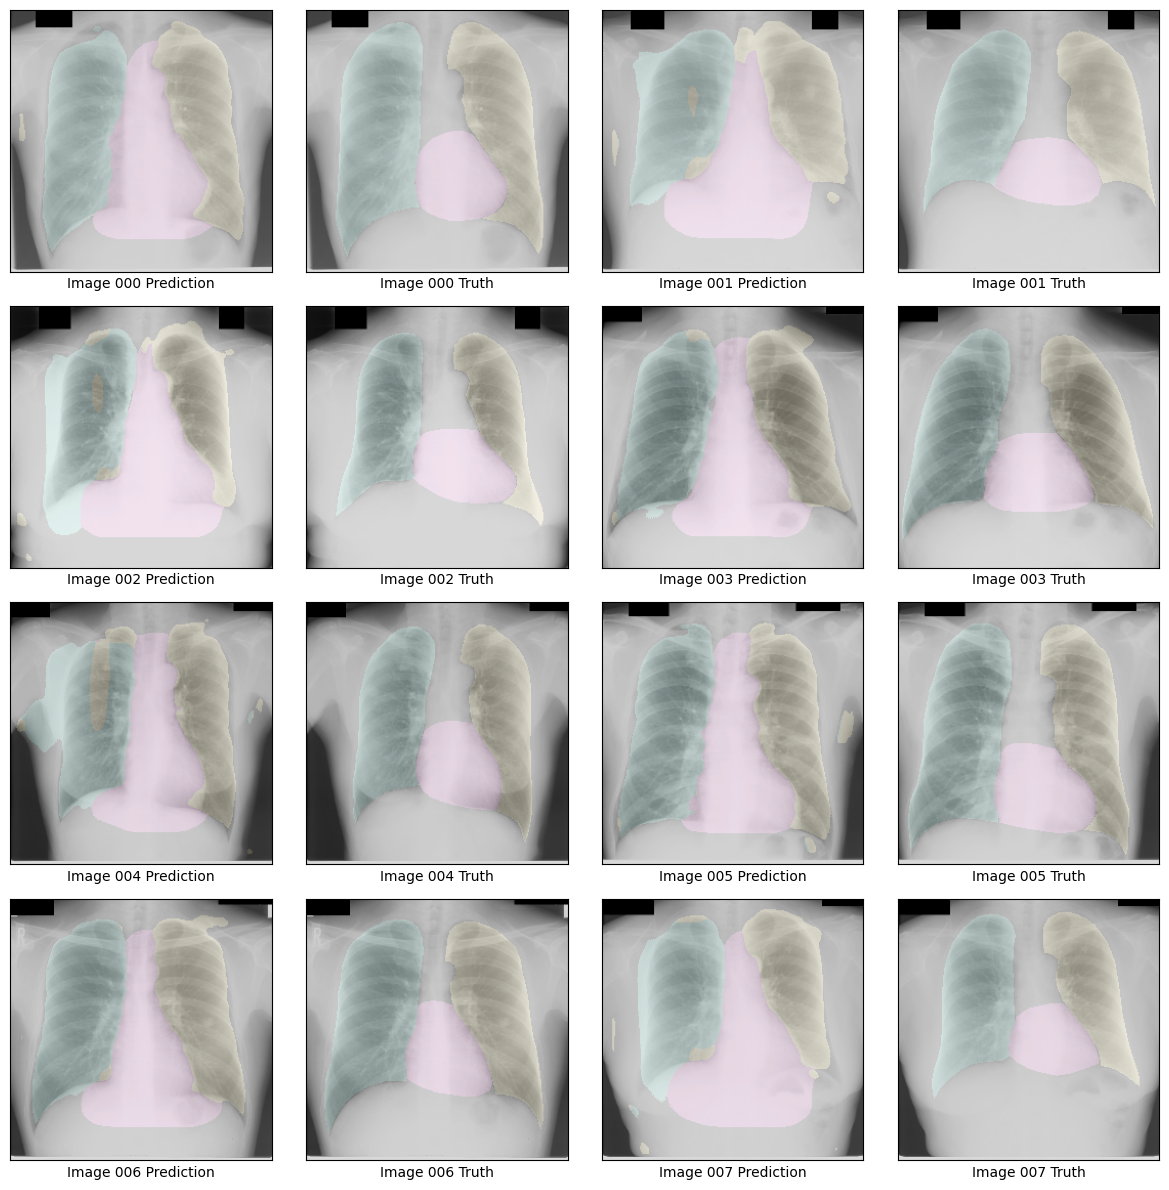

In [ ]:
import numpy as np

LUT = {  # Using a accessible color palette
    1: (68, 170, 153),
    2: (221, 204, 119),
    3: (170, 68, 153)
}

with torch.inference_mode():
    model.eval()  # Network in evaluation mode
    preds = []
    images = []
    labels = []
    for test_data in test_loader:  # Loop through the testing data
        test_images, test_labels = test_data['img'].to(device), test_data['seg'].to(device)
        preds.append(model(test_images).argmax(dim=1).squeeze().cpu().numpy())  # Forward pass and use argmax to get predicted labels
        images.append(test_images.squeeze().cpu().numpy())
        labels.append(test_labels.squeeze().cpu().numpy())
pred = np.concatenate(preds, axis=0)
image = np.concatenate(images, axis=0)
label = np.concatenate(labels, axis=0)

def dice_coefficient_per_class(array1, array2, class_value):
    # Create binary masks for the specific class value
    mask1 = (array1 == class_value)
    mask2 = (array2 == class_value)
    
    # Calculate the Dice coefficient for the specific class
    intersection = np.logical_and(mask1, mask2)
    dice = (2.0 * intersection.sum()) / (mask1.sum() + mask2.sum())
    return dice

print(f"Right Lung: {dice_coefficient_per_class(pred, label, 1)}")
print(f"Left Lung: {dice_coefficient_per_class(pred, label, 2)}")
print(f"Heart: {dice_coefficient_per_class(pred, label, 3)}")
    
plt.subplots(4, 4, figsize=(12, 12))
for idx in range(8):
    im = image[idx, :, :]

    # Normalize the image values to match color map (0, 255)
    im = im - np.min(im)
    im = np.array(im / np.percentile(im, 99) * 255.0)  # Why not use the max?
    im[im > 255] = 255
    im = im.astype(np.ubyte)  # Need integer values

    lbl = label[idx, :, :]
    prd = pred[idx, :, :]

    # Generate a RGB image from our labels
    lut = np.zeros((256, 3))
    for k, v in LUT.items():
        lut[k, :] = v
    colored = np.zeros(lbl.shape + (3,))
    for j in range(3):
        colored[lbl > 0, j] = np.take(lut[:, j], lbl[lbl > 0])

    # Generate a RGB image from our predictions
    colored_pred = np.zeros(prd.shape + (3,))
    for j in range(3):
        colored_pred[prd > 0, j] = np.take(lut[:, j], prd[prd > 0])

    im = np.repeat(im[:, :, np.newaxis], 3, axis=2)  # Make our greyscale image have "color"
    final_im = ((colored * 0.15) + (im * (1-0.15))).astype(np.ubyte)
    final_im_pred = ((colored_pred * 0.15) + (im * (1-0.15))).astype(np.ubyte)

    plt.subplot(4, 4, 2*idx + 1)
    plt.xlabel("Image %03d Prediction" % idx)
    plt.imshow(final_im_pred.transpose(1, 0, 2))
    plt.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
    
    plt.subplot(4, 4, 2*idx + 2)
    plt.xlabel("Image %03d Truth" % idx)
    plt.imshow(final_im.transpose(1, 0, 2))
    plt.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

# Your Code

## Final Tasks
1. Retrieve your DX image from the DicomWeb Service (Week 3/Midterm)
2. Run the model above with pretrained weights (Week 6/Week 7)

download_url = https://drive.google.com/uc?id=1FZXZL41gioeGOfKgmkFBOjEV1ETLIKqk
md5 = cf458ea93498ccfe1170f8633cf61f4f

3. Create a Segmentation Storage DICOM Object
  - Look through the training data used in this notebook, they are all paired DX and SEG images
4. Send your DICOM object to the DicomWeb Service (Week 3/Midterm)
5. Retrieve the 'PATIENT^BLAKE' DX image (Week 3/Midterm)
6. Retrain/Finetune this network to improve results (Week 7)
7. Create a Segmentation Storage DICOM object for the result on 'PATIENT^BLAKE'
8. Send the object to the DicomWeb Service


## Things you might need:
- Remember to replace the StudyUID, SessionUID, SOPInstanceUID!!
- Training data from this notebook to see examples of Segmentation Storage DICOM Objects
- Dataset/Transforms/Network/Training Code from this notebook
- Viewing code from this notebook to visualize results
- DicomWeb interaction examples from Midterm and Week 3

In [7]:
from requests.auth import HTTPBasicAuth
from google.colab import drive
!pip install pydicom
!apt-get install dicom3tools 

import pydicom
from pydicom.sequence import Sequence
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import generate_uid
import os
import tempfile
import datetime
import json
import urllib.request

import subprocess
from pathlib import Path
from google.colab import drive

!pip install pydicom pynetdicom

import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import generate_uid
from pydicom.sequence import Sequence
from pydicom import dcmread

from pynetdicom import AE
from pynetdicom.sop_class import CTImageStorage
from pynetdicom.sop_class import VLPhotographicImageStorage
from pynetdicom.sop_class import StudyRootQueryRetrieveInformationModelFind
from pynetdicom import evt, build_role, debug_logger
from pynetdicom.sop_class import StudyRootQueryRetrieveInformationModelGet
from pynetdicom.sop_class import VLPhotographicImageStorage

import time

from PIL import Image
import urllib.request
import requests

drive.mount('/content/drive')

print("Libraries imported!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript libgs9
  libgs9-common libidn11 libijs-0.35 libjbig2dec0 libnetpbm10 netpbm
  poppler-data
Suggested packages:
  pvrg-jpeg fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  dicom3tools fonts-droid-fallback fonts-noto-mono fonts-urw-base35
  ghostscript libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libnetpbm10 netpbm poppler-data
0 upgraded, 13 newly installed, 0 to remove and 24 not upgraded.
Need to get 21.6 MB of archives.
After th

**Retrieve your DX image from the DicomWeb Service (Week 3/Midterm):**

In [ ]:
# bearer_token = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyIsImtpZCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyJ9.eyJhdWQiOiJodHRwczovL2RpY29tLmhlYWx0aGNhcmVhcGlzLmF6dXJlLmNvbSIsImlzcyI6Imh0dHBzOi8vc3RzLndpbmRvd3MubmV0LzlmYTRmNDM4LWIxZTYtNDczYi04MDNmLTg2ZjhhZWRmMGRlYy8iLCJpYXQiOjE2ODM3Nzc0NDcsIm5iZiI6MTY4Mzc3NzQ0NywiZXhwIjoxNjgzNzgyODU1LCJhY3IiOiIxIiwiYWlvIjoiQVZRQXEvOFRBQUFBNWRyQjRhUktHWUsvVWppb08ybFAvRk1BcmxYSjlGSG1JNStLVjRZdmNGRmN6NUJZU1l5RDRVamJqcHlFS3FPbXdPZ1FqVU4rcHF5Mlg2NHdXSUY0aVlRQnRtWHVLcmt5cEp5cFEyS0lzRmc9IiwiYW1yIjpbInB3ZCIsIm1mYSJdLCJhcHBpZCI6IjE5NTBhMjU4LTIyN2ItNGUzMS1hOWNmLTcxNzQ5NTk0NWZjMiIsImFwcGlkYWNyIjoiMCIsImZhbWlseV9uYW1lIjoiWXUiLCJnaXZlbl9uYW1lIjoiWml4dWFuIiwiaXBhZGRyIjoiMjAuMjMxLjEyNi4yNDUiLCJuYW1lIjoiWml4dWFuIFl1Iiwib2lkIjoiNDc3OTNhNTEtMWI2Yi00MTIxLWI4ZmYtNWU4NDhhZTM3ZWQ0Iiwib25wcmVtX3NpZCI6IlMtMS01LTIxLTEyMTQ0NDAzMzktNDg0NzYzODY5LTcyNTM0NTU0My01NDI3NDIzIiwicHVpZCI6IjEwMDMyMDAxNEUyNjY0OUIiLCJyaCI6IjAuQVFnQU9QU2tuLWF4TzBlQVA0YjRydDhON0w4bDUzWE9adXBNbTVwY1RLcmxmek1JQUVBLiIsInNjcCI6InVzZXJfaW1wZXJzb25hdGlvbiIsInN1YiI6IkdjWE56SE54ZDFhdnJDLUxSOFV3WDQ2Qm4xT0c3cFQ5TDZXaEdDcUZjUmMiLCJ0aWQiOiI5ZmE0ZjQzOC1iMWU2LTQ3M2ItODAzZi04NmY4YWVkZjBkZWMiLCJ1bmlxdWVfbmFtZSI6Inp5dTY0QGpoLmVkdSIsInVwbiI6Inp5dTY0QGpoLmVkdSIsInV0aSI6IndkTjVhOEZ0TEVha0xsMHVwZVJ6QUEiLCJ2ZXIiOiIxLjAifQ.QtaStqUG8B2SSGsjJQA1Wvu3rZJoyppsjqo-fHJjX1JubvqNBTvEz66wx5wWbnzc3qkx8zRq-h5WuoeJgW91RsCaq-zmCo8cThSPW9K_mdu7O_xsAnc61NSjGwVtSpjDvQCnekYOWB2Ds2TY_XXSZ8co-GlRSbC7QoAo6h_JPPpX0sDFzp0a6d1AVT1dtB-moeajKwIZAmvY4wajsh6FXlxQL6f6cBQPWH7_upbM5FJDR0uX7XBurzFZdluxf1zfUY_KIYUfdrIiFH7grTuIXIYAlZ8PUYY-Z4Q7wgcQ82fnuYFk9K6PaKzpDf1qW_xnb_88TK8dt-lleNPIYM2pIQ'
# bearer_token = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyIsImtpZCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyJ9.eyJhdWQiOiJodHRwczovL2RpY29tLmhlYWx0aGNhcmVhcGlzLmF6dXJlLmNvbSIsImlzcyI6Imh0dHBzOi8vc3RzLndpbmRvd3MubmV0LzlmYTRmNDM4LWIxZTYtNDczYi04MDNmLTg2ZjhhZWRmMGRlYy8iLCJpYXQiOjE2ODQzMzk1MjIsIm5iZiI6MTY4NDMzOTUyMiwiZXhwIjoxNjg0MzQzNTg1LCJhY3IiOiIxIiwiYWlvIjoiQVZRQXEvOFRBQUFBRjlnNENyNWdKc0I1bzVFeHpva2RxQ2Y2d0Q1d2QvanNIaUpuN01yR2hNakVjZkpGYjNhRGRsSEJtbFh4ejhjVmdjYmV6dUxVT1lLRTlJeGxhRjVPL01UcXdCYWtYUXpNc1BoR2IxZ3NlZVE9IiwiYW1yIjpbInB3ZCIsIm1mYSJdLCJhcHBpZCI6IjE5NTBhMjU4LTIyN2ItNGUzMS1hOWNmLTcxNzQ5NTk0NWZjMiIsImFwcGlkYWNyIjoiMCIsImZhbWlseV9uYW1lIjoiWXUiLCJnaXZlbl9uYW1lIjoiWml4dWFuIiwiaXBhZGRyIjoiMjAuMjMyLjEwOC42NyIsIm5hbWUiOiJaaXh1YW4gWXUiLCJvaWQiOiI0Nzc5M2E1MS0xYjZiLTQxMjEtYjhmZi01ZTg0OGFlMzdlZDQiLCJvbnByZW1fc2lkIjoiUy0xLTUtMjEtMTIxNDQ0MDMzOS00ODQ3NjM4NjktNzI1MzQ1NTQzLTU0Mjc0MjMiLCJwdWlkIjoiMTAwMzIwMDE0RTI2NjQ5QiIsInJoIjoiMC5BUWdBT1BTa24tYXhPMGVBUDRiNHJ0OE43TDhsNTNYT1p1cE1tNXBjVEtybGZ6TUlBRUEuIiwic2NwIjoidXNlcl9pbXBlcnNvbmF0aW9uIiwic3ViIjoiR2NYTnpITnhkMWF2ckMtTFI4VXdYNDZCbjFPRzdwVDlMNldoR0NxRmNSYyIsInRpZCI6IjlmYTRmNDM4LWIxZTYtNDczYi04MDNmLTg2ZjhhZWRmMGRlYyIsInVuaXF1ZV9uYW1lIjoienl1NjRAamguZWR1IiwidXBuIjoienl1NjRAamguZWR1IiwidXRpIjoiYmJtdkdMUzI4RVNSeXdHMGNvbVpBQSIsInZlciI6IjEuMCJ9.f9Vd5sb2rEkXNnGSJK6pD3aUt-Aa0tj_oEVSGx75wSh4WLryyxavTtaWdDw23QxvxI2fPiKDvDe9ig2BqJvDHsXVx96Un15lmgUSNiMEuH3VSZo7SfHMRbJOK1Og0Hk19_-77aK1COWT3ibhjr7zEVsBkNGdUY_RpdtKyBTs69wkKug1iye_15UYavpQoJH6l3_L9s9XEyX9E9HTVE4yUE2o-Wd8XcwcryjT36GqIenN1Ci71IJUTuMgapp3jMTYz65w2gvxGFj3t5DBq-rj13jOoJvT2j2cy5ktPmhSng1OhBr04RhRIAHxATBHiKEjSePiNIM0sJOZxWnT5zWU3w'
# bearer_token = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyIsImtpZCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyJ9.eyJhdWQiOiJodHRwczovL2RpY29tLmhlYWx0aGNhcmVhcGlzLmF6dXJlLmNvbSIsImlzcyI6Imh0dHBzOi8vc3RzLndpbmRvd3MubmV0LzlmYTRmNDM4LWIxZTYtNDczYi04MDNmLTg2ZjhhZWRmMGRlYy8iLCJpYXQiOjE2ODQzNDQ2NDMsIm5iZiI6MTY4NDM0NDY0MywiZXhwIjoxNjg0MzUwMzIzLCJhY3IiOiIxIiwiYWlvIjoiQVZRQXEvOFRBQUFBMjhPdmRod2FJR2NRdEIrQi8xK2Rtd09zbDUyNGV5RXNQZmlhZUNwZlJxbEVPUUk1eHhYMTdWejZ0VTJ1dGlvOXplcldKN3pVYktMNDFZQnJTU0NBTldDVVF3UXdQSk5xMWJiN2RJTHR4Vlk9IiwiYW1yIjpbInB3ZCIsIm1mYSJdLCJhcHBpZCI6IjE5NTBhMjU4LTIyN2ItNGUzMS1hOWNmLTcxNzQ5NTk0NWZjMiIsImFwcGlkYWNyIjoiMCIsImZhbWlseV9uYW1lIjoiWXUiLCJnaXZlbl9uYW1lIjoiWml4dWFuIiwiaXBhZGRyIjoiMjAuMjMxLjEyNi4xNiIsIm5hbWUiOiJaaXh1YW4gWXUiLCJvaWQiOiI0Nzc5M2E1MS0xYjZiLTQxMjEtYjhmZi01ZTg0OGFlMzdlZDQiLCJvbnByZW1fc2lkIjoiUy0xLTUtMjEtMTIxNDQ0MDMzOS00ODQ3NjM4NjktNzI1MzQ1NTQzLTU0Mjc0MjMiLCJwdWlkIjoiMTAwMzIwMDE0RTI2NjQ5QiIsInJoIjoiMC5BUWdBT1BTa24tYXhPMGVBUDRiNHJ0OE43TDhsNTNYT1p1cE1tNXBjVEtybGZ6TUlBRUEuIiwic2NwIjoidXNlcl9pbXBlcnNvbmF0aW9uIiwic3ViIjoiR2NYTnpITnhkMWF2ckMtTFI4VXdYNDZCbjFPRzdwVDlMNldoR0NxRmNSYyIsInRpZCI6IjlmYTRmNDM4LWIxZTYtNDczYi04MDNmLTg2ZjhhZWRmMGRlYyIsInVuaXF1ZV9uYW1lIjoienl1NjRAamguZWR1IiwidXBuIjoienl1NjRAamguZWR1IiwidXRpIjoiRTM1dUNWX19mRWVZQWlsWFN4c0VBQSIsInZlciI6IjEuMCJ9.Xz8Fl2YGda1CansasYeSs5GVQ3YBUOYMhRrchYCY-RWqveW_AmkatZ7G-MesG9ZRkUSi7jmuln5cchFVgK5U7RYuMdYzAXIcQuCYg4UMJmlr_TMLUSVADajgclpjb0iUYuGtxs1ZvVk52f0CqnOFWnfgOj8rjvrfnqdKVfOouJAAWmuvgkCzTeTqKFswblhvYSDZnyEVOvGu8_kQOr4s3BhRrT3RGyDPzOTgnjMxpBpYWRD0RzK9vhGYqBmVIYjjwqfjJC7EQmOQXJqkiFU2d-bJRCwCzAmD68AChdkHv9jY-E10KF2HJlv1BOkY_dIBq5Kemn0hoCBmj54K6kd1rQ'
bearer_token = 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsIng1dCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyIsImtpZCI6Ii1LSTNROW5OUjdiUm9meG1lWm9YcWJIWkdldyJ9.eyJhdWQiOiJodHRwczovL2RpY29tLmhlYWx0aGNhcmVhcGlzLmF6dXJlLmNvbSIsImlzcyI6Imh0dHBzOi8vc3RzLndpbmRvd3MubmV0LzlmYTRmNDM4LWIxZTYtNDczYi04MDNmLTg2ZjhhZWRmMGRlYy8iLCJpYXQiOjE2ODQzNTMwNTIsIm5iZiI6MTY4NDM1MzA1MiwiZXhwIjoxNjg0MzU3NTIxLCJhY3IiOiIxIiwiYWlvIjoiQVZRQXEvOFRBQUFBQUJlSm9sam8waU1mZ0lwcGdTSnpXS1U0c3dLYytxdVJFYjVlamN5MDE5WGlXU0dvcCtmZ3RhYVhCMmw5TndnSWhZN1AxQTgxcVMvYWtqZ3djZnlqV1prbEJrb1dnUmZOSE5aMEFCc1hHVms9IiwiYW1yIjpbInB3ZCIsIm1mYSJdLCJhcHBpZCI6IjE5NTBhMjU4LTIyN2ItNGUzMS1hOWNmLTcxNzQ5NTk0NWZjMiIsImFwcGlkYWNyIjoiMCIsImZhbWlseV9uYW1lIjoiWXUiLCJnaXZlbl9uYW1lIjoiWml4dWFuIiwiaXBhZGRyIjoiMjAuMTI0LjEzMy4xMTIiLCJuYW1lIjoiWml4dWFuIFl1Iiwib2lkIjoiNDc3OTNhNTEtMWI2Yi00MTIxLWI4ZmYtNWU4NDhhZTM3ZWQ0Iiwib25wcmVtX3NpZCI6IlMtMS01LTIxLTEyMTQ0NDAzMzktNDg0NzYzODY5LTcyNTM0NTU0My01NDI3NDIzIiwicHVpZCI6IjEwMDMyMDAxNEUyNjY0OUIiLCJyaCI6IjAuQVFnQU9QU2tuLWF4TzBlQVA0YjRydDhON0w4bDUzWE9adXBNbTVwY1RLcmxmek1JQUVBLiIsInNjcCI6InVzZXJfaW1wZXJzb25hdGlvbiIsInN1YiI6IkdjWE56SE54ZDFhdnJDLUxSOFV3WDQ2Qm4xT0c3cFQ5TDZXaEdDcUZjUmMiLCJ0aWQiOiI5ZmE0ZjQzOC1iMWU2LTQ3M2ItODAzZi04NmY4YWVkZjBkZWMiLCJ1bmlxdWVfbmFtZSI6Inp5dTY0QGpoLmVkdSIsInVwbiI6Inp5dTY0QGpoLmVkdSIsInV0aSI6IkZNb29xclBMZUVpOU9JMG1QMmtVQUEiLCJ2ZXIiOiIxLjAifQ.HIb46BMHeZ0mjtow3lK-lKOr9-byYUsBzKVinxdI9pDYxNwVcSW69CmEbh8FIzBDC74EBfTiEloEgSo8A2r3pgkd5IQrMGhbwUmwJ8Ku7r-YM9S3pMDqko_5u6VYPd1fokiL9c0qOWOjnrWNgfZMOmE1X4s8r6SeF_9WlqYkNfHfBMaPWzWkhwVc5Py-fp_fgdBrtXMVpA8_a0XIy-CTM8wQWNWZunLMYiMc_WWGAMtdPL4PLAh93Pczdmlew7H3kzLcJuUGfVqrqtloD0ri3iWyTte3FiIEOVntmdq69FLUXdtkOnk_aaMUtrWpMRvh5TfoRXsubvNUXJZnt6jFGQ'
base_dicomweb_url = 'https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1'

In [ ]:

patient_name="Zixuan"
querystring = {'PatientName' : patient_name,'fuzzymatching' : 'true'}
headers = {
    'Accept': "application/json",
    'Authorization': 'Bearer ' + bearer_token
    }
 
response = requests.request("GET", base_dicomweb_url + '/studies/', data="", headers=headers, params=querystring)
json_response = json.loads(response.text)
json_formatted = json.dumps(json_response, indent=2)

print(json_formatted)

[
  {
    "00080020": {
      "vr": "DA",
      "Value": [
        "20230501"
      ]
    },
    "00080030": {
      "vr": "TM",
      "Value": [
        "194332.842501"
      ]
    },
    "00080050": {
      "vr": "SH",
      "Value": [
        "12456456"
      ]
    },
    "00080090": {
      "vr": "PN",
      "Value": [
        {
          "Alphabetic": "SAMPLE^PHYSICIAN"
        }
      ]
    },
    "00100010": {
      "vr": "PN",
      "Value": [
        {
          "Alphabetic": "PATIENT^ZIXUAN"
        }
      ]
    },
    "00100020": {
      "vr": "LO",
      "Value": [
        "123123"
      ]
    },
    "00100030": {
      "vr": "DA",
      "Value": [
        "20230501"
      ]
    },
    "00100040": {
      "vr": "CS",
      "Value": [
        "M"
      ]
    },
    "0020000D": {
      "vr": "UI",
      "Value": [
        "2.25.300324652226055100428292497380674303450"
      ]
    },
    "00200010": {
      "vr": "SH",
      "Value": [
        "12456456"
      ]
    }
  },
  

In [ ]:
# Set up your query parameters
querystring = {
    'PatientName': 'PATIENT^ZIXUAN',
    #'Modality': 'DX',
    'includefield': 'SeriesInstanceUID,SOPInstanceUID'
}

# Set up your headers
headers = {
    'Accept': "application/json",
    'Authorization': 'Bearer ' + bearer_token
}

# Make your request
response = requests.request("GET", dicomweb_study_query_url, headers=headers, params=querystring)

# Process the response
json_response = json.loads(response.text)


In [ ]:
patient_name="PATIENT^Zixuan"
querystring = {'PatientName' : patient_name, 'includefield' : 'SeriesInstanceUID,SOPInstanceUID'}

headers = {
    'Accept': "application/json",
    'Authorization': 'Bearer ' + bearer_token
    }

# get first study 
dicomweb_study_query_url =  base_dicomweb_url + '/studies/'
print ("fetching " + dicomweb_study_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Study details", response.text)
json_response = json.loads(response.text)
query_study_uid = json_response[0]["0020000D"]["Value"][0]
print ("Study Instance UID: " + query_study_uid + "\n")

# get first series of first study 
dicomweb_series_query_url =  dicomweb_study_query_url + str(query_study_uid) + '/series/'
print ("fetching " + dicomweb_series_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Series details", response.text)
json_response = json.loads(response.text)
query_series_uid = json_response[0]["0020000E"]["Value"][0]
print ("Series Instance UID: " + query_series_uid + "\n")

# get first instance of first series of first study 
dicomweb_instance_query_url =  dicomweb_series_query_url + str(query_series_uid) + '/instances/'
print ("fetching " + dicomweb_instance_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Instance details", response.text)
json_response = json.loads(response.text)
query_instance_uid = json_response[0]["00080018"]["Value"][0]
print ("SOP Instance UID: " + query_instance_uid)



fetching https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1/studies/
Study details [{"00080018":{"vr":"UI","Value":["2.25.125155155410362789644003657239890524305"]},"00080020":{"vr":"DA","Value":["20230501"]},"00080030":{"vr":"TM","Value":["194332.842501"]},"00080050":{"vr":"SH","Value":["12456456"]},"00080090":{"vr":"PN","Value":[{"Alphabetic":"SAMPLE^PHYSICIAN"}]},"00100010":{"vr":"PN","Value":[{"Alphabetic":"PATIENT^ZIXUAN"}]},"00100020":{"vr":"LO","Value":["123123"]},"00100030":{"vr":"DA","Value":["20230501"]},"00100040":{"vr":"CS","Value":["M"]},"0020000D":{"vr":"UI","Value":["2.25.300324652226055100428292497380674303450"]},"0020000E":{"vr":"UI","Value":["2.25.252313324198718108040175164364548553955"]},"00200010":{"vr":"SH","Value":["12456456"]}},{"00080018":{"vr":"UI","Value":["2.25.187111597361850839233352371565932583569"]},"00080020":{"vr":"DA","Value":["20230409"]},"00080030":{"vr":"TM","Value":["043819.970231"]},"00080050":{"vr":"SH","Value":["12456456"]},"00080090"

In [ ]:
working_dir = '/content/drive/My Drive/'
wadors_path = base_dicomweb_url + '/studies/' + query_study_uid + '/series/' + query_series_uid + '/instances/' + query_instance_uid
wadors_local_file_path = working_dir + "/wadors_retrieve.dcm"
print(wadors_local_file_path)
wadors_file_out = open(wadors_local_file_path, 'wb')

print ("retrieving " + wadors_path)

headers = {
    'Accept': 'application/dicom;',
    'Authorization': 'Bearer ' + bearer_token
    }

response = requests.request("GET", wadors_path, data="", headers=headers, params=querystring)
wadors_file_out.write(response.content)

print("code: " + str(response.status_code))
print("reason: " + response.reason)

wadors_file_out.close()


/content/drive/My Drive//wadors_retrieve.dcm
retrieving https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1/studies/2.25.300324652226055100428292497380674303450/series/2.25.252313324198718108040175164364548553955/instances/2.25.125155155410362789644003657239890524305
code: 200
reason: OK


In [ ]:
# Check the modality
ds = pydicom.dcmread(wadors_local_file_path)

if ds.Modality == 'DX':
    print("The modality is DX")
else:
    print(f"The modality is {ds.Modality}, not DX")

The modality is DX


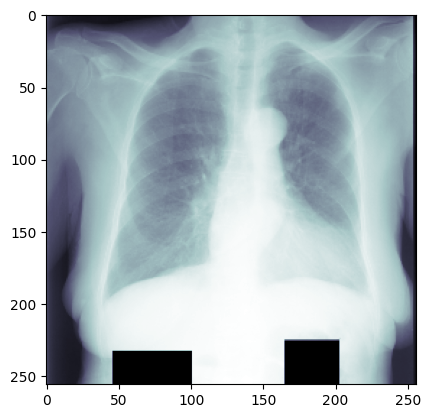

In [8]:
# display the pics
import pydicom
import matplotlib.pyplot as plt

dicom_file_path = "/content/drive/My Drive/wadors_retrieve.dcm"

ds = pydicom.dcmread(dicom_file_path)

# Get the pixel data from the DICOM file
image = ds.pixel_array

# Display the image
plt.imshow(image, cmap=plt.cm.bone)
plt.show()


In [ ]:
# Download the pre-trained weights

root_dir = Path('/content')
resource = "https://drive.google.com/uc?id=1FZXZL41gioeGOfKgmkFBOjEV1ETLIKqk"
md5 = "cf458ea93498ccfe1170f8633cf61f4f"  # A hash value to check the integrity of our download

compressed_file = root_dir / "weight.zip"  # Specify out download locations (Path objects use "/" to combine)
data_dir = root_dir / "weight_file"

#download_and_extract(resource, compressed_file, root_dir, md5)

working_dir = '/content/drive/My Drive/'
download_and_extract(resource, compressed_file, working_dir, md5)
# the file pre-trained weight file name: pretrained_chestxray.pth

Downloading...
From: https://drive.google.com/uc?id=1FZXZL41gioeGOfKgmkFBOjEV1ETLIKqk
To: /tmp/tmp9cr3ksqt/weight.zip
100%|██████████| 115M/115M [00:01<00:00, 102MB/s]

2023-05-18 04:23:27,449 - INFO - Downloaded: /content/weight.zip


2023-05-18 04:23:28,048 - INFO - Verified 'weight.zip', md5: cf458ea93498ccfe1170f8633cf61f4f.
2023-05-18 04:23:28,053 - INFO - Writing into directory: /content/drive/My Drive/.


In [ ]:
import pydicom
import numpy as np
import torch
import matplotlib.pyplot as plt

# Using an accessible color palette
LUT = {  
    1: (68, 170, 153),
    2: (221, 204, 119),
    3: (170, 68, 153)
}

# Load the image
# Path to the DICOM file
dicom_file_path = "/content/drive/My Drive/wadors_retrieve.dcm"
# Read the DICOM file
ds = pydicom.dcmread(dicom_file_path)
# Get the pixel data from the DICOM file
image = ds.pixel_array

# Convert it to a PyTorch tensor
# then move it to device
image_tensor = torch.from_numpy(image.astype(np.float32)[np.newaxis, np.newaxis, ...]).to(device)

with torch.inference_mode():
  model.load_state_dict(torch.load('/content/drive/My Drive/pretrained_chestxray.pth', map_location=torch.device('cpu')))
  # model.to(device)
  model.eval()  # Network in evaluation mode
  pred = model(image_tensor).argmax(dim=1).squeeze().cpu().numpy()  # Forward pass and use argmax to get predicted labels


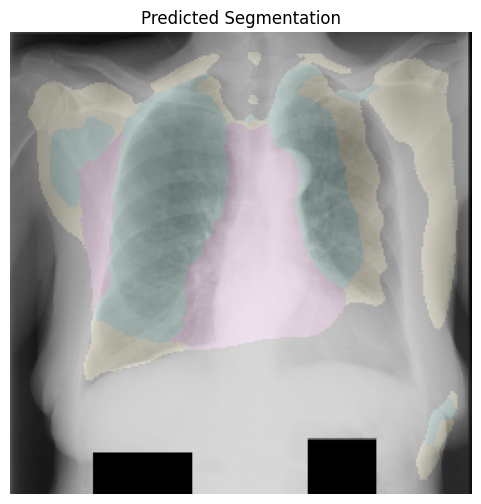

In [ ]:
# Normalize the image values to match color map (0, 255)
im = image - np.min(image)
im = np.array(im / np.percentile(im, 99) * 255.0)  # Why not use the max?
im[im > 255] = 255
im = im.astype(np.ubyte)  # Need integer values

# Generate a RGB image from our predictions
lut = np.zeros((256, 3))
for k, v in LUT.items():
    lut[k, :] = v

colored_pred = np.zeros(pred.shape + (3,))
for j in range(3):
    colored_pred[pred > 0, j] = np.take(lut[:, j], pred[pred > 0])

im = np.repeat(im[:, :, np.newaxis], 3, axis=2)  # Make our greyscale image have "color"
final_im_pred = ((colored_pred * 0.15) + (im * (1-0.15))).astype(np.ubyte)

# Display the prediction
plt.figure(figsize=(6, 6))
plt.title("Predicted Segmentation")
plt.imshow(final_im_pred, cmap='gray')
plt.axis('off')
plt.show()


### Generate a Segmentation DICOM file from the prediction

In [9]:
# preparing for the seg
#from pydicom.dataset import Dataset, Sequence, FileDataset
import pydicom
from pydicom.uid import generate_uid
import numpy as np
from pydicom.pixel_data_handlers.numpy_handler import pack_bits
from pydicom.sequence import Sequence
import datetime
import tempfile

# Prepare the SegmentSequence
segment_sequence = Sequence()

# Define segment properties for each part
segment_properties = [
    {
        'segment_number': 1,
        'segment_label': 'Right Lung',
        'code_value': '361967000',
        'code_meaning': 'Entire Right Lung',
    },
    {
        'segment_number': 2,
        'segment_label': 'Left Lung',
        'code_value': '361982005',
        'code_meaning': 'Entire Left Lung',
    },
    {
        'segment_number': 3,
        'segment_label': 'Heart',
        'code_value': '302509004',
        'code_meaning': 'Entire Heart',
    },
]

# Create each item in SegmentSequence
for prop in segment_properties:
    segment_item = Dataset()

    # Segmented Property Category Code Sequence
    segment_property_category_code_sequence = Sequence()
    segment_property_category_item = Dataset()
    segment_property_category_item.CodeValue = '123037004'
    segment_property_category_item.CodingSchemeDesignator = 'SCT'
    segment_property_category_item.CodeMeaning = 'Anatomical Structure'
    segment_property_category_code_sequence.append(segment_property_category_item)
    
    segment_item.SegmentedPropertyCategoryCodeSequence = segment_property_category_code_sequence

    # Other attributes
    segment_item.SegmentNumber = prop['segment_number']
    segment_item.SegmentLabel = prop['segment_label']
    segment_item.SegmentAlgorithmType = 'MANUAL'

    # Segmented Property Type Code Sequence
    segmented_property_type_code_sequence = Sequence()
    segmented_property_type_item = Dataset()
    segmented_property_type_item.CodeValue = prop['code_value']
    segmented_property_type_item.CodingSchemeDesignator = 'SCT'
    segmented_property_type_item.CodeMeaning = prop['code_meaning']
    segmented_property_type_code_sequence.append(segmented_property_type_item)

    segment_item.SegmentedPropertyTypeCodeSequence = segmented_property_type_code_sequence

    segment_sequence.append(segment_item)




In [10]:
# new version


# Load original DICOM
orig_dcm = pydicom.dcmread('/content/drive/My Drive/wadors_retrieve.dcm')

# Create a new DICOM dataset

# Set up the file
sop_instance_uid = generate_uid(prefix=None)
working_dir = '/content/drive/My Drive/'
dicom_file = tempfile.NamedTemporaryFile(dir=working_dir, prefix=sop_instance_uid, suffix='.dcm').name

# Set up the envelope
sop_class = '1.2.840.10008.5.1.4.1.1.66.4'
ds_basemetadata = Dataset()
ds_basemetadata.MediaStorageSOPClassUID = sop_class
ds_basemetadata.ImplementationClassUID = sop_class
ds_basemetadata.MediaStorageSOPInstanceUID = sop_instance_uid

new_dcm = FileDataset(dicom_file, {}, file_meta=ds_basemetadata, preamble=b"\0" * 128)
new_dcm.is_little_endian = True
new_dcm.is_implicit_VR = True
new_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

# Copy over the necessary patient and study attributes from the original DICOM
new_dcm.PatientID = orig_dcm.PatientID
new_dcm.PatientName = orig_dcm.PatientName
new_dcm.PatientBirthDate = orig_dcm.PatientBirthDate
new_dcm.PatientSex = orig_dcm.PatientSex
new_dcm.StudyDate = orig_dcm.StudyDate
new_dcm.StudyTime = orig_dcm.StudyTime
new_dcm.StudyID = orig_dcm.StudyID
new_dcm.SeriesNumber = orig_dcm.SeriesNumber
new_dcm.InstanceNumber = orig_dcm.InstanceNumber
new_dcm.ReferringPhysicianName = orig_dcm.ReferringPhysicianName
new_dcm.Manufacturer = orig_dcm.Manufacturer
new_dcm.ManufacturerModelName = orig_dcm.ManufacturerModelName
new_dcm.ContentDate = orig_dcm.ContentDate
new_dcm.ContentTime = orig_dcm.ContentTime

# Set segmentation specific attributes
new_dcm.ImageType = ["DERIVED", "PRIMARY"]
new_dcm.SegmentationType = "BINARY"
new_dcm.SamplesPerPixel = 1
new_dcm.PhotometricInterpretation = "MONOCHROME2"
new_dcm.PixelRepresentation = 0
new_dcm.BitsStored = 1
new_dcm.BitsAllocated = 1
new_dcm.HighBit = 0
new_dcm.Rows = orig_dcm.Rows
new_dcm.Columns = orig_dcm.Columns
new_dcm.ImageLaterality = 'U' 
new_dcm.ContentLabel = 'DX_SEG'
new_dcm.ContentDescription = ''
new_dcm.AccessionNumber = '123456'
new_dcm.DeviceSerialNumber = "123456"  # Replace with actual value
new_dcm.SoftwareVersions = "v1.0"  # Replace with actual value
new_dcm.PatientOrientation = ""  # Can be an empty string if not applicable
new_dcm.LossyImageCompression = "00"  # No lossy compression
new_dcm.FrameOfReferenceUID = generate_uid()

# Assign the sequence to the main DICOM dataset
new_dcm.SegmentSequence = segment_sequence
new_dcm.SegmentationType = 'BINARY'
new_dcm.SegmentsOverlap = 'NO'

# Generate new StudyInstanceUID, SeriesInstanceUID, and SOPInstanceUID
new_dcm.StudyInstanceUID = generate_uid()
new_dcm.SeriesInstanceUID = generate_uid()
new_dcm.SOPInstanceUID = generate_uid()

# Update necessary DICOM metadata fields
new_dcm.SOPClassUID = pydicom.uid.SegmentationStorage

# Content creator's name (0070, 0084) should be your full name (e.g. 'DEWEY^BLAKE')
new_dcm.add_new(0x00700084, 'PN', 'YU^ZIXUAN')

# Change the pieces that need changed (Modality, SOPClass, etc.)
new_dcm.Modality = 'SEG'
new_dcm.SOPClassUID = pydicom.uid.SegmentationStorage


# Remove the pieces that are not needed
if (0x0028, 0x0000) in new_dcm:
    del new_dcm[0x0028, 0x0000]

# Prepare PixelData for the Segmentation
pred = model(image_tensor).argmax(dim=1).squeeze().cpu().numpy() 
pixel_array = pred.astype(np.uint8).squeeze()
pixel_array = pixel_array[np.newaxis, ...]
full_pixel_array = np.array([], np.bool_)

for i in range(1, 4):
  planes = np.zeros(pixel_array.shape, dtype=np.uint8)
  planes[pixel_array == i] = 1
  full_pixel_array = np.concatenate([full_pixel_array, planes[0].T.flatten()])
new_dcm.PixelData = pack_bits(full_pixel_array.flatten())

# Save new DICOM file
new_dcm.save_as('/content/drive/My Drive/myres.dcm')


NameError: ignored

In [ ]:
print(new_dcm)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Segmentation Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.224995722885258393709330924133643345067
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: Segmentation Storage
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Segmentation Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.98712817796237027901836808283944897707
(0008, 0020) Study Date                          DA: '20230501'
(0008, 0030) Study Time                          TM: '194332.842501'
(0008, 0050) Accession Number                    SH: '123456'
(0008, 0060) Modality                            CS: 'SEG'
(0008, 0070) Manufacturer                        LO: 

#### Verify DICOM object

In [ ]:
!apt-get install dicom3tools #install dicom3tools

print ('Done loading dicom3tools!')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dicom3tools is already the newest version (1.00~20190724083540-1build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Done loading dicom3tools!


In [ ]:
dataset_read = '/content/drive/My Drive/myres.dcm'
print('Verifying ', dataset_read)
os.environ["DICOM_FILE_TO_VERIFY"] = dataset_read

!dciodvfy "$DICOM_FILE_TO_VERIFY"

Verifying  /content/drive/My Drive/myres.dcm
Error - Media Storage SOP Instance UID different from SOP Instance UID
Error - PixelData has incorrect value length - expected 8192 dec - got 24576 dec
Segmentation
Error - Missing attribute Type 1 Required Element=<FileMetaInformationGroupLength> Module=<FileMetaInformation>
Error - Missing attribute Type 1 Required Element=<FileMetaInformationVersion> Module=<FileMetaInformation>
Error - Missing attribute Type 2 Required Element=<PositionReferenceIndicator> Module=<FrameOfReference>
Error - Missing attribute Type 1 Required Element=<NumberOfFrames> Module=<MultiFrameFunctionalGroupsCommon>
Error - Missing attribute Type 1 Required Element=<SharedFunctionalGroupsSequence> Module=<MultiFrameFunctionalGroupsForSegmentation>
Error - Missing attribute Type 1 Required Element=<PerFrameFunctionalGroupsSequence> Module=<MultiFrameFunctionalGroupsForSegmentation>
Error - Missing attribute Type 1 Required Element=<DimensionOrganizationSequence> Modu

#### Push the new file back to the Azure DICOMWeb Service

In [ ]:
# Read the DICOM file
ds = pydicom.dcmread('/content/drive/My Drive/myres.dcm')

# Check the modality
if ds.Modality == 'SEG':
    print("The modality is SEG")
else:
    print(f"The modality is {ds.Modality}, not SEG")

The modality is SEG


#### Retrieve the DICOM file from the Azure DICOMWeb Service for patient 'PATIENT^BLAKE'.
Remember to get the 'DX' modality

In [ ]:
# Print all all studies with name as BLAKE
querystring = {
    'PatientName': 'PATIENT^BLAKE',
    'includefield': 'all'
}

headers = {
    'Accept': "application/json",
    'Authorization': 'Bearer ' + bearer_token
}

response = requests.request("GET", dicomweb_study_query_url, headers=headers, params=querystring)

json_response = json.loads(response.text)

for study in json_response:
    study_id = study.get('0020000D', {}).get('Value', [None])[0]
    modality = study.get('00080060', {}).get('Value', [None])[0]
    print(f'Study ID: {study_id}, Modality: {modality}')


Study ID: 2.25.334517547077131921178610423878294101547, Modality: None
Study ID: 2.25.42889439861563393553935812293476275563, Modality: None
Study ID: 2.25.75788313329435555941778172734235938015, Modality: None
Study ID: 2.25.13467182202680223663542269916067544219, Modality: None
Study ID: 2.25.63704558223506714286926773221331542699, Modality: None
Study ID: 2.25.45551556745145313595174876718716894569, Modality: None
Study ID: 2.25.104678311050745808517793983830323777841, Modality: None


In [ ]:
patient_name="PATIENT^BLAKE"
querystring = {'PatientName' : patient_name, 
               'ModalitiesInStudy' : 'DX',
               'includefield' : 'SeriesInstanceUID,SOPInstanceUID'}

headers = {
    'Accept': "application/json",
    'Authorization': 'Bearer ' + bearer_token
    }

# get first study 
dicomweb_study_query_url =  base_dicomweb_url + '/studies/'
print ("fetching " + dicomweb_study_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Study details", response.text)
json_response = json.loads(response.text)
query_study_uid = json_response[0]["0020000D"]["Value"][0]
print ("Study Instance UID: " + query_study_uid + "\n")

# get first series of first study 
dicomweb_series_query_url =  dicomweb_study_query_url + str(query_study_uid) + '/series/'
print ("fetching " + dicomweb_series_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Series details", response.text)
json_response = json.loads(response.text)
query_series_uid = json_response[0]["0020000E"]["Value"][0]
print ("Series Instance UID: " + query_series_uid + "\n")

# get first instance of first series of first study 
dicomweb_instance_query_url =  dicomweb_series_query_url + str(query_series_uid) + '/instances/'
print ("fetching " + dicomweb_instance_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Instance details", response.text)
json_response = json.loads(response.text)
query_instance_uid = json_response[0]["00080018"]["Value"][0]
print ("SOP Instance UID: " + query_instance_uid)



fetching https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1/studies/
Study details [{"00080018":{"vr":"UI","Value":["2.25.339815839154786298028344573251297405443"]},"00080020":{"vr":"DA","Value":["20230501"]},"00080030":{"vr":"TM","Value":["194330.618750"]},"00080050":{"vr":"SH","Value":["12456456"]},"00080061":{"vr":"CS","Value":["DX"]},"00080090":{"vr":"PN","Value":[{"Alphabetic":"SAMPLE^PHYSICIAN"}]},"00100010":{"vr":"PN","Value":[{"Alphabetic":"PATIENT^BLAKE"}]},"00100020":{"vr":"LO","Value":["123123"]},"00100030":{"vr":"DA","Value":["20230501"]},"00100040":{"vr":"CS","Value":["M"]},"0020000D":{"vr":"UI","Value":["2.25.63704558223506714286926773221331542699"]},"0020000E":{"vr":"UI","Value":["2.25.170315401296616879903566254366024539605"]},"00200010":{"vr":"SH","Value":["12456456"]}}]
Study Instance UID: 2.25.63704558223506714286926773221331542699

fetching https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1/studies/2.25.63704558223506714286926773221331542699/seri

In [ ]:

dicomweb_study_query_url =  base_dicomweb_url + '/studies/'
print ("fetching " + dicomweb_study_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Study details", response.text)

json_response = json.loads(response.text)
query_study_uid = json_response[0]["0020000D"]["Value"][0]
print ("Study Instance UID: " + query_study_uid + "\n")

dicomweb_series_query_url =  dicomweb_study_query_url + str(query_study_uid) + '/series/'
print ("fetching " + dicomweb_series_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Series details", response.text)

json_response = json.loads(response.text)
query_series_uid = json_response[0]["0020000E"]["Value"][0]
print ("Series Instance UID: " + query_series_uid + "\n")

dicomweb_instance_query_url =  dicomweb_series_query_url + str(query_series_uid) + '/instances/'
print ("fetching " + dicomweb_instance_query_url)
response = requests.request("GET", dicomweb_study_query_url, data="", headers=headers, params=querystring)
print ("Instance details", response.text)

json_response = json.loads(response.text)
query_instance_uid = json_response[0]["00080018"]["Value"][0]
print ("SOP Instance UID: " + query_instance_uid)

working_dir = '/content/drive/My Drive/'
wadors_path = base_dicomweb_url + '/studies/' + query_study_uid + '/series/' + query_series_uid + '/instances/' + query_instance_uid
wadors_local_file_path2 = working_dir + "/wadors_retrieve_black.dcm"
print(wadors_local_file_path2)
wadors_file_out = open(wadors_local_file_path2, 'wb')

print ("retrieving " + wadors_path)

headers = {
    'Accept': 'application/dicom;',
    'Authorization': 'Bearer ' + bearer_token
}

response = requests.request("GET", wadors_path, data="", headers=headers, params=querystring)
wadors_file_out.write(response.content)

print("code: " + str(response.status_code))
print("reason: " + response.reason)

wadors_file_out.close()


fetching https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1/studies/
Study details [{"00080018":{"vr":"UI","Value":["2.25.339815839154786298028344573251297405443"]},"00080020":{"vr":"DA","Value":["20230501"]},"00080030":{"vr":"TM","Value":["194330.618750"]},"00080050":{"vr":"SH","Value":["12456456"]},"00080061":{"vr":"CS","Value":["DX"]},"00080090":{"vr":"PN","Value":[{"Alphabetic":"SAMPLE^PHYSICIAN"}]},"00100010":{"vr":"PN","Value":[{"Alphabetic":"PATIENT^BLAKE"}]},"00100020":{"vr":"LO","Value":["123123"]},"00100030":{"vr":"DA","Value":["20230501"]},"00100040":{"vr":"CS","Value":["M"]},"0020000D":{"vr":"UI","Value":["2.25.63704558223506714286926773221331542699"]},"0020000E":{"vr":"UI","Value":["2.25.170315401296616879903566254366024539605"]},"00200010":{"vr":"SH","Value":["12456456"]}}]
Study Instance UID: 2.25.63704558223506714286926773221331542699

fetching https://jhdicom1-jhdicomweb.dicom.azurehealthcareapis.com/v1/studies/2.25.63704558223506714286926773221331542699/seri

In [ ]:
# Read the DICOM file
ds = pydicom.dcmread(wadors_local_file_path2)

# Check the modality
if ds.Modality == 'DX':
    print("The modality is DX")
else:
    print(f"The modality is {ds.Modality}, not DX")

The modality is DX


#### Retrain the model

In [ ]:
import torch
from monai.transforms import Compose, ToTensord, EnsureChannelFirstd, ScaleIntensityd, RandRotated, RandZoomd
from monai.data import DataLoader

# We will be using Dictionary Transforms to apply to both images and segmentations
train_transforms = Compose(  # Compose chains transforms into a pipeline
    [
        ToTensord(['img'], dtype=torch.float),  # ToTensor takes numpy arrays and creates PyTorch Tensors
        ToTensord(['seg'], dtype=torch.int),  # Make sure the segmentations are integers
        EnsureChannelFirstd(['img', 'seg'], channel_dim='no_channel'),  # Ensure we have a channel dimension (B&W images could just be 2D)
        ScaleIntensityd(['img']),  # Scale the intensity of the images to [0, 1]
        RandRotated(['img', 'seg'], range_x=np.pi / 18, prob=0.25, keep_size=True),  # Apply a random rotation to the image and seg
        RandZoomd(['img', 'seg'], min_zoom=0.9, max_zoom=1.1, prob=0.25, keep_size=True),  # Apply a random zoom to the image and seg
    ]
)

val_transforms = Compose(  # Compose chains transforms into a pipeline
    [
        ToTensord(['img'], dtype=torch.float),  # ToTensor takes numpy arrays and creates PyTorch Tensors
        ToTensord(['seg'], dtype=torch.int),  # Make sure the segmentations are integers
        EnsureChannelFirstd(['img', 'seg'], channel_dim='no_channel'),  # Ensure we have a channel dimension (B&W images could just be 2D)
        ScaleIntensityd(['img']),  # Scale the intensity of the images to [0, 1]
    ]
)

train_ds = DicomDataset(train_image_files[:130], train_label_files[:130], train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = DicomDataset(train_image_files[130:140], train_label_files[130:140], val_transforms)
val_loader = DataLoader(val_ds, batch_size=8, num_workers=2)

test_ds = DicomDataset(train_image_files[140:], train_label_files[140:], val_transforms)
test_loader = DataLoader(test_ds, batch_size=8, num_workers=2)

In [ ]:
import torch
from torch.optim.lr_scheduler import StepLR
from monai.losses import DiceLoss
from monai.networks.nets import BasicUnet
from torch.nn import Dropout, BatchNorm2d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Regularization
dropout_layer = Dropout(p=0.5) 

# Batch Normalization
batch_norm = BatchNorm2d(num_features=1)

model = BasicUnet(spatial_dims=2, in_channels=1, out_channels=4, features=(64, 128, 256, 512, 1024, 64)).to(device)
model = torch.nn.Sequential(dropout_layer, batch_norm, model)  # add Dropout and BatchNorm before the model

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)  # AdamW includes L2 regularization

loss_func = DiceLoss(to_onehot_y=True, softmax=True)  # DiceLoss from MONAI
val_loss_func = DiceLoss(to_onehot_y=True, softmax=True)  # DiceLoss from MONAI

BasicUNet features: (64, 128, 256, 512, 1024, 64).


We use the GeneralizedDiceLoss function.

We could 1) add number of epoches, 2)implement early stopping, 3)use a learning rate scheduler to help model converge faster 4)Augmenting the data so that we could increase the generalizability of the model

In [ ]:
# BLAKE's new model
import torch
from monai.losses import DiceLoss
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Setup device, model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We are using the UNet model which has a flexible depth configuration
# start with 5 layers:

model = UNet(spatial_dims=2, in_channels=1, out_channels=4, channels=(64, 128, 256, 512, 1024), strides=(2, 2, 2, 2)).to(device)
# model = BasicUnet(spatial_dims=2, in_channels=1, out_channels=4, features=(64, 128, 256, 512, 1024, 64)).to(device)

optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# DiceLoss is commonly used for segmentation tasks. We continue to use it here.
loss_func = DiceLoss(to_onehot_y=True, softmax=True)
val_loss_func = DiceLoss(to_onehot_y=True, softmax=True)

# Set up training parameters
num_epochs = 50
val_interval = 1
best_loss = 1
best_loss_epoch = -1
early_stopping_patience = 3
early_stopping_min_delta = 0.001
epochs_no_improve = 0

# Set up learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)

epoch_loss_values = []

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    for batch_idx, batch_data in enumerate(train_loader):
        imgs, segs = batch_data['img'].to(device), batch_data['seg'].to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_func(outputs, segs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * imgs.shape[0]
        print(f"{batch_idx + 1}/{len(train_loader)}, " f"train_loss: {loss.item():.4f}")

    epoch_loss /= len(train_ds)
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.inference_mode():
            loss = 0
            for val_data in val_loader:
                val_imgs, val_segs = val_data['img'].to(device), val_data['seg'].to(device)
                loss += val_loss_func(model(val_imgs), val_segs).item() * val_imgs.shape[0]
            avg_loss = loss / len(val_ds)
            
            # Update learning rate
            scheduler.step(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss
                best_loss_epoch = epoch + 1
                torch.save(model.state_dict(), root_dir / "best_metric_model.pth")
                print("saved new best metric model")
                epochs_no_improve = 0
            else:
                # Early stopping
                if abs(avg_loss - best_loss) < early_stopping_min_delta:
                    epochs_no_improve += 1
                else:
                    epochs_no_improve = 0

            if epochs_no_improve == early_stopping_patience:
                print("Early stopping!")
                break

            print(f"current epoch: {epoch + 1} current loss: {avg_loss}")


----------
epoch 1/50
1/17, train_loss: 0.7812
2/17, train_loss: 0.7632
3/17, train_loss: 0.7421
4/17, train_loss: 0.7431
5/17, train_loss: 0.7232
6/17, train_loss: 0.7046
7/17, train_loss: 0.7098
8/17, train_loss: 0.6938
9/17, train_loss: 0.6832
10/17, train_loss: 0.6750
11/17, train_loss: 0.6795
12/17, train_loss: 0.6643
13/17, train_loss: 0.6408
14/17, train_loss: 0.6657
15/17, train_loss: 0.6193
16/17, train_loss: 0.6315
17/17, train_loss: 0.5968
epoch 1 average loss: 0.6935
saved new best metric model
current epoch: 1 current loss: 0.6093405485153198
----------
epoch 2/50
1/17, train_loss: 0.6082
2/17, train_loss: 0.5881
3/17, train_loss: 0.5873
4/17, train_loss: 0.5811
5/17, train_loss: 0.5887
6/17, train_loss: 0.5674
7/17, train_loss: 0.5567
8/17, train_loss: 0.5693
9/17, train_loss: 0.5250
10/17, train_loss: 0.5311
11/17, train_loss: 0.5159
12/17, train_loss: 0.5116
13/17, train_loss: 0.5030
14/17, train_loss: 0.5072
15/17, train_loss: 0.4976
16/17, train_loss: 0.4758
17/17, tr

Right Lung: 0.9753929695485184
Left Lung: 0.974186483982368
Heart: 0.9348020761787182


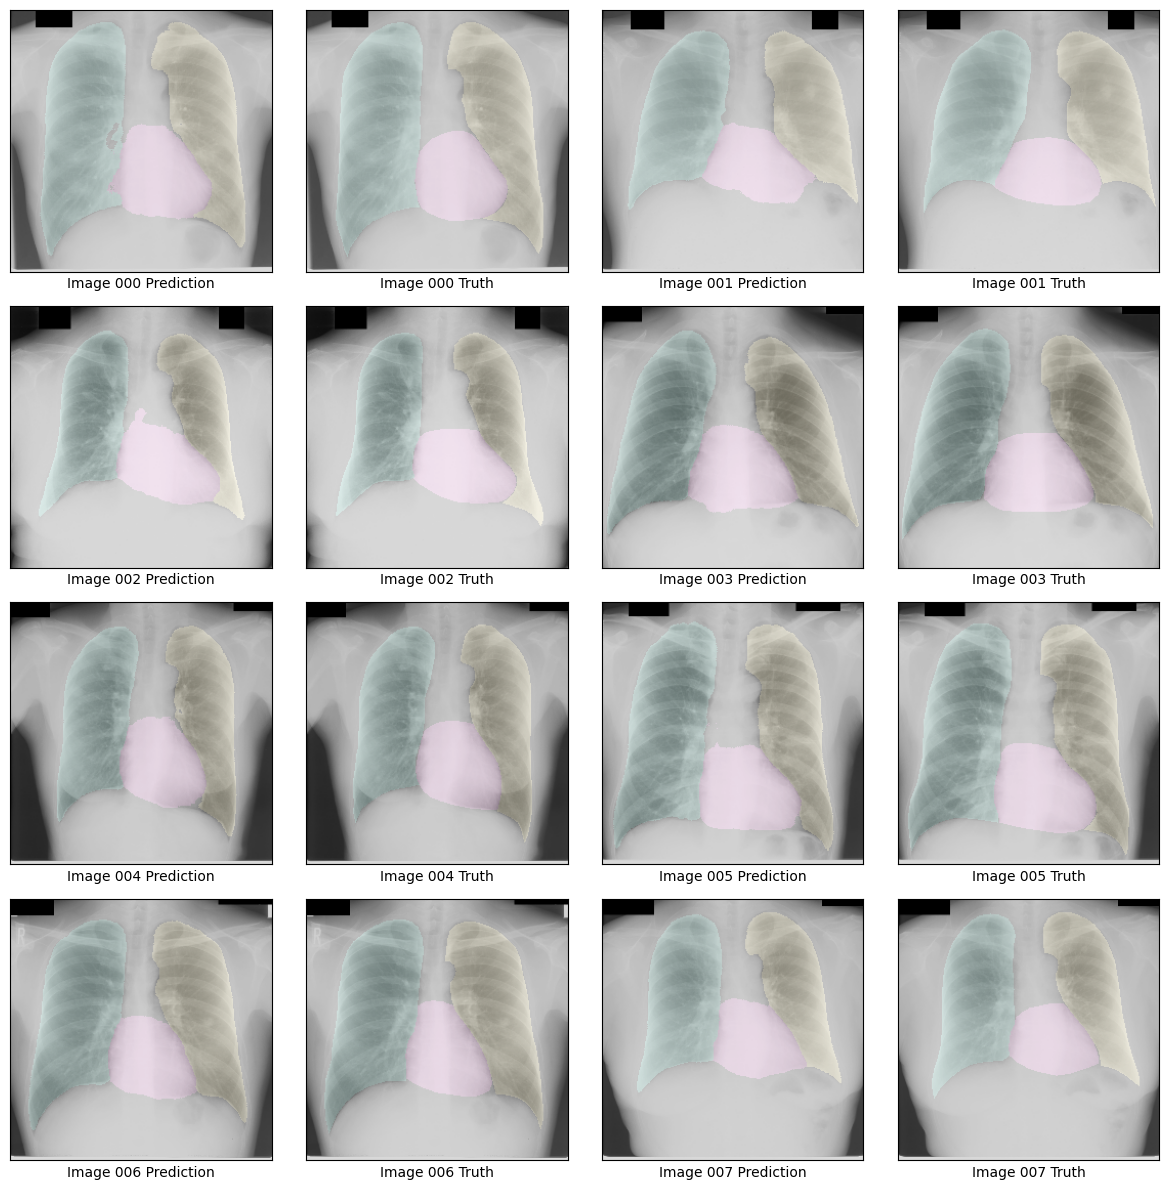

In [ ]:
## testing again
import numpy as np

LUT = {  # Using a accessible color palette
    1: (68, 170, 153),
    2: (221, 204, 119),
    3: (170, 68, 153)
}

with torch.inference_mode():
    model.eval()  # Network in evaluation mode
    preds = []
    images = []
    labels = []
    for test_data in test_loader:  # Loop through the testing data
        test_images, test_labels = test_data['img'].to(device), test_data['seg'].to(device)
        preds.append(model(test_images).argmax(dim=1).squeeze().cpu().numpy())  # Forward pass and use argmax to get predicted labels
        images.append(test_images.squeeze().cpu().numpy())
        labels.append(test_labels.squeeze().cpu().numpy())
pred = np.concatenate(preds, axis=0)
image = np.concatenate(images, axis=0)
label = np.concatenate(labels, axis=0)

def dice_coefficient_per_class(array1, array2, class_value):
    # Create binary masks for the specific class value
    mask1 = (array1 == class_value)
    mask2 = (array2 == class_value)
    
    # Calculate the Dice coefficient for the specific class
    intersection = np.logical_and(mask1, mask2)
    dice = (2.0 * intersection.sum()) / (mask1.sum() + mask2.sum())
    return dice

print(f"Right Lung: {dice_coefficient_per_class(pred, label, 1)}")
print(f"Left Lung: {dice_coefficient_per_class(pred, label, 2)}")
print(f"Heart: {dice_coefficient_per_class(pred, label, 3)}")
    
plt.subplots(4, 4, figsize=(12, 12))
for idx in range(8):
    im = image[idx, :, :]

    # Normalize the image values to match color map (0, 255)
    im = im - np.min(im)
    im = np.array(im / np.percentile(im, 99) * 255.0)  # Why not use the max?
    im[im > 255] = 255
    im = im.astype(np.ubyte)  # Need integer values

    lbl = label[idx, :, :]
    prd = pred[idx, :, :]

    # Generate a RGB image from our labels
    lut = np.zeros((256, 3))
    for k, v in LUT.items():
        lut[k, :] = v
    colored = np.zeros(lbl.shape + (3,))
    for j in range(3):
        colored[lbl > 0, j] = np.take(lut[:, j], lbl[lbl > 0])

    # Generate a RGB image from our predictions
    colored_pred = np.zeros(prd.shape + (3,))
    for j in range(3):
        colored_pred[prd > 0, j] = np.take(lut[:, j], prd[prd > 0])

    im = np.repeat(im[:, :, np.newaxis], 3, axis=2)  # Make our greyscale image have "color"
    final_im = ((colored * 0.15) + (im * (1-0.15))).astype(np.ubyte)
    final_im_pred = ((colored_pred * 0.15) + (im * (1-0.15))).astype(np.ubyte)

    plt.subplot(4, 4, 2*idx + 1)
    plt.xlabel("Image %03d Prediction" % idx)
    plt.imshow(final_im_pred.transpose(1, 0, 2))
    plt.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
    
    plt.subplot(4, 4, 2*idx + 2)
    plt.xlabel("Image %03d Truth" % idx)
    plt.imshow(final_im.transpose(1, 0, 2))
    plt.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


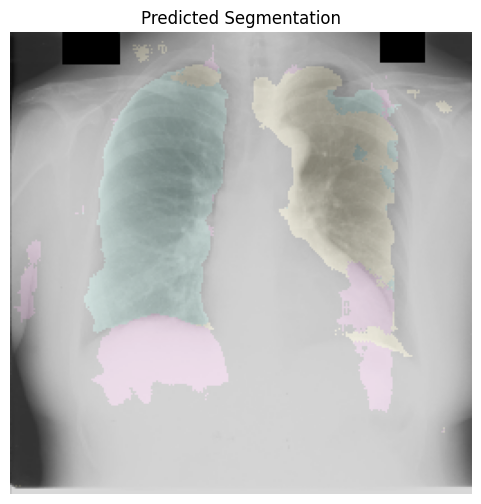

In [ ]:
#blake verify
import pydicom
import numpy as np
import torch
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Using an accessible color palette
LUT = {  
    1: (68, 170, 153),
    2: (221, 204, 119),
    3: (170, 68, 153)
}

# Load the image
# Path to the Blake's DICOM file

# Read the DICOM file
working_dir = '/content/drive/My Drive/'
wadors_local_file_path2 = working_dir + "/wadors_retrieve_black.dcm"

ds = pydicom.dcmread(wadors_local_file_path2)
# Get the pixel data from the DICOM file
image = ds.pixel_array

# Convert it to a PyTorch tensor
# then move it to device
image_tensor = torch.from_numpy(image.astype(np.float32)[np.newaxis, np.newaxis, ...]).to(device)

with torch.inference_mode():
  model.to(device)
  model.eval()  # Network in evaluation mode
  pred = model(image_tensor).argmax(dim=1).squeeze().cpu().numpy()  # Forward pass and use argmax to get predicted labels


# Normalize the image values to match color map (0, 255)
im = image - np.min(image)
im = np.array(im / np.percentile(im, 99) * 255.0)  # Why not use the max?
im[im > 255] = 255
im = im.astype(np.ubyte)  # Need integer values

# Generate a RGB image from our predictions
lut = np.zeros((256, 3))
for k, v in LUT.items():
    lut[k, :] = v

colored_pred = np.zeros(pred.shape + (3,))
for j in range(3):
    colored_pred[pred > 0, j] = np.take(lut[:, j], pred[pred > 0])

im = np.repeat(im[:, :, np.newaxis], 3, axis=2)  # Make our greyscale image have "color"
final_im_pred = ((colored_pred * 0.15) + (im * (1-0.15))).astype(np.ubyte)

# Display the prediction
plt.figure(figsize=(6, 6))
plt.title("Predicted Segmentation")
plt.imshow(final_im_pred, cmap='gray')
plt.axis('off')
plt.show()
